In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor as RFR
from  sklearn.utils import resample
import scipy.stats as st
import math as m

In [2]:
data = pd.read_csv('insurance.csv', sep=',')
data_train = data.sample(frac=0.9)
data_validate = data.loc[~data.index.isin(data_train.index)]
data_train

,age,sex,bmi,children,smoker,region,charges
1156,19,male,44.880,0,yes,southeast,39722.74620
655,52,female,25.300,2,yes,southeast,24667.41900
71,31,male,28.500,5,no,northeast,6799.45800
1,18,male,33.770,1,no,southeast,1725.55230
760,22,female,34.580,2,no,northeast,3925.75820
...,...,...,...,...,...,...,...
714,24,female,22.600,0,no,southwest,2457.50200
774,41,male,34.200,2,no,northwest,7261.74100
278,59,male,31.790,2,no,southeast,12928.79110
1157,23,female,23.180,2,no,northwest,14426.07385


# **L1 CONFIDENCE INTERVAL 95**

**CREATE COLUMN TRANSFORMER**

In [3]:
col_trans_l1 = ColumnTransformer([
    ('scaller', StandardScaler(), ['age', 'bmi', 'children']),
    ('hot_encode', OneHotEncoder(handle_unknown='ignore', drop='first'), ['sex', 'smoker', 'region']),
], remainder='passthrough')

**CREATE PIPE**

In [4]:
pipe_l1 = Pipeline([
    ('col_trans_l1', col_trans_l1), 
    ('poly', PolynomialFeatures(degree=4, include_bias=False)), 
    ('lasso', Lasso(alpha=69.56552173913043))
])

In [5]:
pipe_l1[0].fit(data_train.loc[:, ~data_train.columns.isin(['charges'])], data_train['charges'])

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaller', StandardScaler(),
                                 ['age', 'bmi', 'children']),
                                ('hot_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['sex', 'smoker', 'region'])])

**L1 RESULTS- BEST TEST SCORE**

In [6]:
def btstrap_cv_score(data, pipe):
    res = np.zeros((300,), dtype=int)
    for i in range(300):
        resampled_data = resample(data)
        res[i] = -np.mean(cross_validate(pipe,
                                         resampled_data.loc[:, ~resampled_data.columns.isin(['charges'])],
                                         resampled_data['charges'],
                                         cv=30,
                                         scoring=('neg_mean_absolute_error',))['test_neg_mean_absolute_error'])
    return res

In [7]:
l1_res = btstrap_cv_score(data_train, pipe_l1)

D:\Programming\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.808e+07, tolerance: 1.633e+07
  model = cd_fast.enet_coordinate_descent(
D:\Programming\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e+07, tolerance: 1.625e+07
  model = cd_fast.enet_coordinate_descent(
D:\Programming\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e+07, tolerance: 

In [8]:
l1_res

array([2967, 3025, 2830, 2986, 2645, 2928, 2826, 2883, 2789, 2785, 2604,
       2931, 2661, 2770, 2727, 2809, 2570, 3090, 2774, 2761, 3040, 2911,
       2915, 2846, 2642, 2760, 2879, 2984, 2475, 2738, 2787, 2574, 2853,
       2863, 3045, 3131, 2708, 2716, 3120, 3057, 2933, 2658, 2806, 2959,
       2868, 2875, 2906, 2956, 2705, 2930, 3074, 2786, 2967, 2751, 2911,
       2724, 2645, 2577, 2629, 2944, 2848, 3111, 2579, 2968, 2794, 2635,
       2719, 2741, 2627, 2980, 2710, 2753, 2697, 2630, 2562, 2940, 2722,
       2609, 2913, 2634, 2901, 2375, 2718, 2644, 2829, 2872, 2923, 3108,
       2767, 2900, 2691, 2398, 2568, 2812, 2832, 2845, 2821, 2887, 2651,
       2718, 2888, 2922, 2326, 2852, 2489, 2891, 2609, 2559, 2857, 2744,
       2860, 2821, 2785, 2607, 2521, 2919, 2982, 2920, 2789, 2902, 2428,
       2661, 2913, 3040, 3005, 2416, 2752, 2835, 3203, 2893, 2963, 2889,
       2605, 2685, 3055, 2581, 2889, 2614, 2765, 2843, 2784, 3201, 2640,
       2805, 2883, 2762, 2714, 2909, 2706, 2498, 31

In [9]:
l1_res_df = pd.DataFrame(data=l1_res, columns=['means'])

**CALCULATE 95% CONFIDENSE INTERVAL**

In [10]:
def conf_interv(array, conf_lvl):
    return (np.mean(array) - conf_lvl * (np.std(array) / m.sqrt(array.shape[0])), np.mean(array) + conf_lvl * (np.std(array) / m.sqrt(array.shape[0])))

In [11]:
conf_interv(l1_res, 1.96)

(2777.819580927515, 2818.1137524058186)

**BUILD HISTOGRAM**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016284207820>]],
      dtype=object)

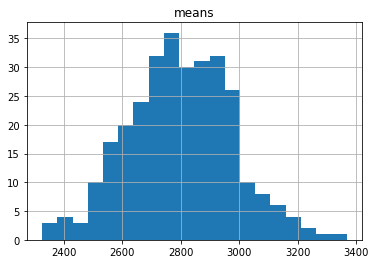

In [12]:
l1_res_df.hist(bins=20)

In [13]:
st.t.interval(alpha=0.95, df=len(l1_res)-1, loc=np.mean(l1_res), scale=st.sem(l1_res))

(2777.704272018029, 2818.2290613153045)

# **L2 95 CONFIDENCE INTERVAL**

**LETS CREATE PIPE (WE CAN USE THE SAME COLUMN TRANSFORMER)**

In [14]:
col_trans_l2 = col_trans_l1

In [15]:
pipe_l2 = Pipeline([
    ('col_trans_l2', col_trans_l2), 
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), 
    ('ridge', Ridge(alpha=1e-05))
])

**CALCULATE RESULTS**

In [16]:
l2_res = btstrap_cv_score(data_train, pipe_l2)

In [17]:
l2_res_df = pd.DataFrame(data=l2_res, columns=['means'])

**BUILD HISTOGRAM**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016284376340>]],
      dtype=object)

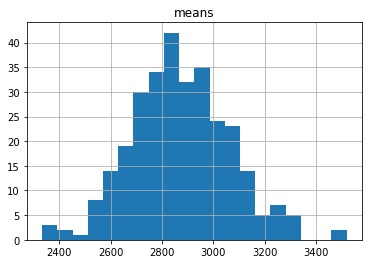

In [18]:
l2_res_df.hist(bins=20)

# **DECISION TREE BOOTSTRAP**

**CREATE COLLUMN TRANSFORMER**

In [19]:
bintree_trans = ColumnTransformer([
    ('encode', OneHotEncoder(handle_unknown='ignore', drop='first'), ['sex', 'smoker', 'region']),]
)

**CREATE PIPELINE**

In [21]:
pipe_bintree = Pipeline([
    ('bintree_trans', bintree_trans), 
    ('bintree', DecisionTreeRegressor(max_depth=5, min_samples_leaf=17))
])

**CALCULATE RESULTS**

In [22]:
bintree_res = btstrap_cv_score(data_train, pipe_bintree)

In [23]:
bintree_df = pd.DataFrame(data=bintree_res, columns=['means'])

**BUILD HISTOGRAM**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000162843883D0>]],
      dtype=object)

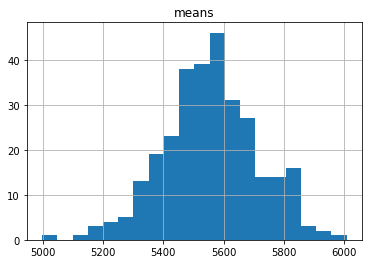

In [24]:
bintree_df.hist(bins=20)